# Cell type enrichment analysis

In [1]:
import os, errno
import functools
import numpy as np
import pandas as pd
import session_info
from pyhere import here
from functools import lru_cache
from matplotlib_venn import venn3
from scipy.stats import fisher_exact
from matplotlib import pyplot as plt
from statsmodels.stats.multitest import multipletests

## Functions

### Cached functions

In [2]:
@lru_cache()
def get_deg(tissue):
    fn = here(f'differential_expression/{tissue}',
              '_m/genes/diffExpr_maleVfemale_full.txt')
    df = pd.read_csv(fn, sep='\t', index_col=0)
    df["ensemblID"] = df.gencodeID.str.replace("\\..*", "", regex=True)
    return df


@lru_cache()
def get_xci():
    xci = pd.read_csv('../_h/xci_status_hg19.txt', sep='\t')
    xci['ensemblID'] = xci['Gene ID'].str.replace("\\..*", "", regex=True)
    return xci

### Simple functions

In [3]:
def tissue_annotation(tissue):
    return {'caudate': "Caudate", "dlpfc": "DLPFC", 
            "hippocampus": "Hippocampus"}[tissue]


def mkdir_p(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def cal_fishers(status, tissue):
    deg = get_deg(tissue)
    xci = get_xci()
    df = deg.merge(xci, on='ensemblID', how='left')
    table = [[np.sum((df['adj.P.Val']<0.05) & (df['Combined XCI status'] == status)), 
              np.sum((df['adj.P.Val']<0.05) & (df['Combined XCI status'] != status))], 
             [np.sum((df['adj.P.Val']>0.05) & (df['Combined XCI status'] == status)), 
              np.sum((df['adj.P.Val']>0.05) & (df['Combined XCI status'] != status))]]
    #print(table)
    return fisher_exact(table)


def cal_fishers_direction(status, direction, tissue):
    deg = get_deg(tissue)
    if direction == 'Up':
        deg = deg[(deg['t'] > 0)].copy()
    else:
        deg = deg[(deg['t'] < 0)].copy()
    xci = get_xci()
    df = deg.merge(xci, on='ensemblID', how='left')
    table = [[np.sum((df['adj.P.Val']<0.05) & (df['Combined XCI status'] == status)), 
              np.sum((df['adj.P.Val']<0.05) & (df['Combined XCI status'] != status))], 
             [np.sum((df['adj.P.Val']>0.05) & (df['Combined XCI status'] == status)), 
              np.sum((df['adj.P.Val']>0.05) & (df['Combined XCI status'] != status))]]
    #print(table)
    return fisher_exact(table)


def cal_fisher_by_xci_status(tissue):
    xci_status = xci = get_xci().loc[:, 'Combined XCI status'].unique()
    xci_lt = []; pval_lt = []; oddratio_lt = []; dir_lt = [];
    for status in xci_status:
        odd_ratio, pval = cal_fishers(status, tissue)
        xci_lt.append(status); pval_lt.append(pval);
        oddratio_lt.append(odd_ratio); dir_lt.append('All')
        if pval < 0.05:
            print("There is a significant enrichment (p-value < %.1e) of %s!" % 
                  (pval, status))

    for status in xci_status:
        odd_ratio, pval = cal_fishers_direction(status, "Up", tissue)
        xci_lt.append(status); pval_lt.append(pval);
        oddratio_lt.append(odd_ratio); dir_lt.append('Male Bias')
        if pval < 0.05:
            print("There is a significant enrichment of male bias genes (p-value < %.1e) of %s!" %
                  (pval, status))
        
    for status in xci_status:
        odd_ratio, pval = cal_fishers_direction(status, "Down", tissue)
        xci_lt.append(status); pval_lt.append(pval);
        oddratio_lt.append(odd_ratio); dir_lt.append('Female Bias')
        if pval < 0.05:
            print("There is a significant enrichment of female bias genes (p-value < %.1e) of %s!" % 
                  (pval, status))
    return pd.DataFrame({"Tissue": tissue_annotation(tissue),
                         'XCI status': xci_lt, 'OR': oddratio_lt, 
                         'PValue': pval_lt, 'Direction': dir_lt})

## Gene set overlaps

Caudate


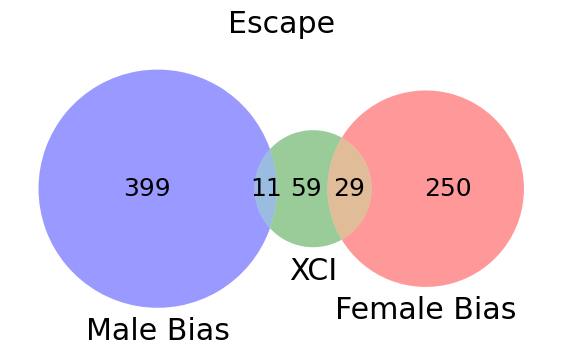

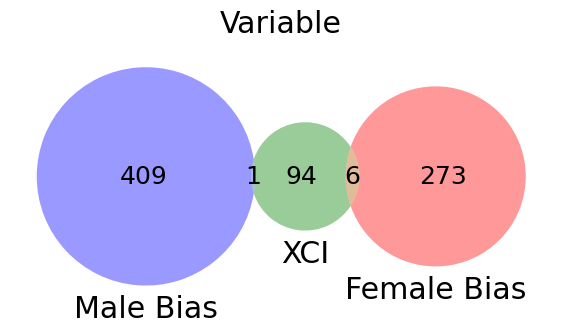

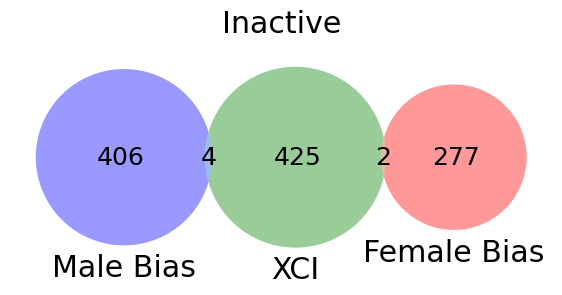

DLPFC


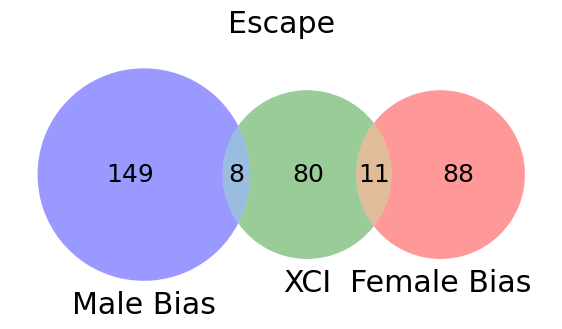

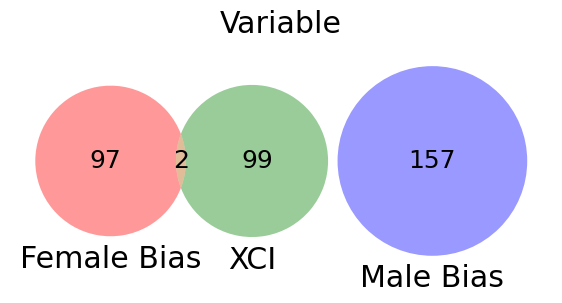

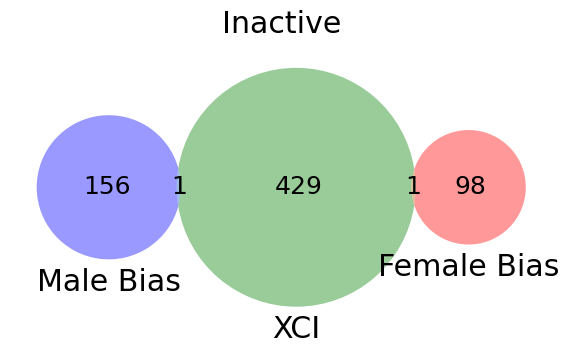

Hippocampus


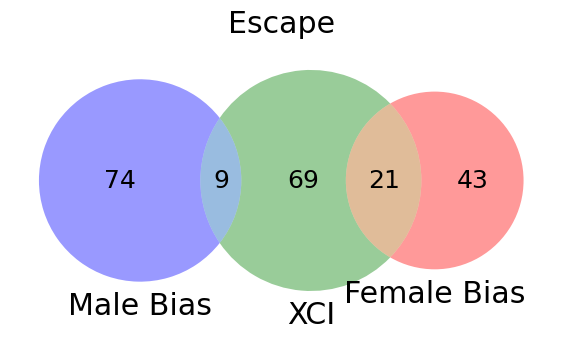

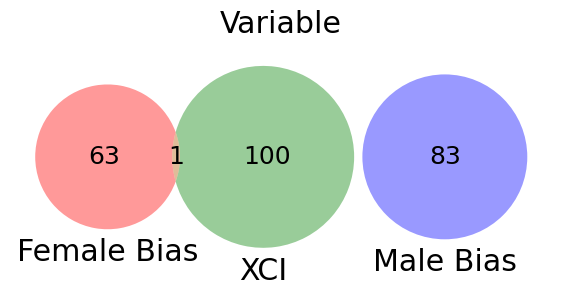

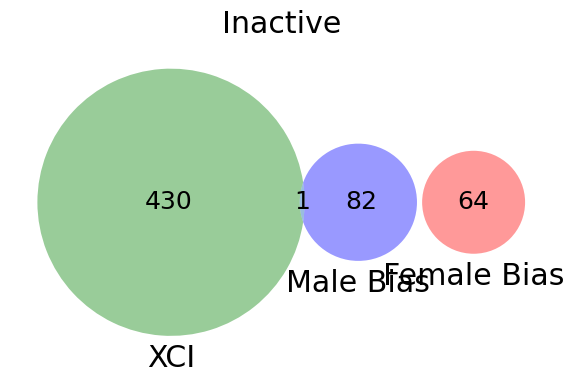

In [4]:
for tissue in ["caudate", "dlpfc", "hippocampus"]:
    mkdir_p(tissue)
    print(tissue_annotation(tissue))
    deg = get_deg(tissue)
    xci = get_xci()
    xci_status = get_xci().loc[:, 'Combined XCI status'].unique()
    ## Plot venn diagram
    for status in xci_status:
        setA = set(deg[(deg["adj.P.Val"] < 0.05) & (deg['t'] < 0)].ensemblID)
        setB = set(xci[(xci["Combined XCI status"] == status)].ensemblID)
        setC = set(deg[(deg["adj.P.Val"] < 0.05) & (deg['t'] > 0)].ensemblID)
        plt.rcParams.update({'font.size': 18})
        plt.figure(figsize=(7,7))
        v = venn3([setA, setB, setC], ("Female Bias", "XCI", "Male Bias"))
        plt.title(status.title())
        fn = f'{tissue}/venn_DEGs_{status}'
        for ext in ['png', 'pdf', 'svg']:
            plt.savefig(fn + '.' + ext) 
        plt.show()

## Calculated fisher's exact for each XCI status

In [5]:
d = dict()
for tissue in ["caudate", "dlpfc", "hippocampus"]:
    print(tissue_annotation(tissue))
    df = cal_fisher_by_xci_status(tissue)
    _, fdr, _, _ = multipletests(df.PValue, method='bonferroni')
    df['Bonferroni'] = fdr
    d[tissue] = df

Caudate
There is a significant enrichment (p-value < 1.9e-43) of escape!
There is a significant enrichment (p-value < 3.6e-03) of variable!
There is a significant enrichment of male bias genes (p-value < 1.2e-10) of escape!
There is a significant enrichment of female bias genes (p-value < 4.8e-36) of escape!
There is a significant enrichment of female bias genes (p-value < 1.5e-04) of variable!
DLPFC
There is a significant enrichment (p-value < 2.4e-22) of escape!
There is a significant enrichment of male bias genes (p-value < 4.7e-10) of escape!
There is a significant enrichment of female bias genes (p-value < 3.8e-14) of escape!
There is a significant enrichment of female bias genes (p-value < 4.0e-02) of variable!
Hippocampus
There is a significant enrichment (p-value < 1.2e-48) of escape!
There is a significant enrichment of male bias genes (p-value < 2.3e-15) of escape!
There is a significant enrichment of female bias genes (p-value < 7.0e-36) of escape!


In [6]:
dft = pd.concat(d.values(), axis=0)
dft[(dft.Bonferroni <= 0.05)]

,Tissue,XCI status,OR,PValue,Direction,Bonferroni
0,Caudate,escape,44.780003,1.914686e-43,All,1.723218e-42
1,Caudate,variable,3.830205,3.593643e-03,All,3.234279e-02
3,Caudate,escape,22.421192,1.180694e-10,Male Bias,1.062625e-09
6,Caudate,escape,74.220667,4.797428e-36,Female Bias,4.317685e-35
7,Caudate,variable,8.719970,1.499181e-04,Female Bias,1.349263e-03
0,DLPFC,escape,39.070402,2.417813e-22,All,2.176032e-21
3,DLPFC,escape,37.710067,4.746765e-10,Male Bias,4.272089e-09
6,DLPFC,escape,45.110294,3.844541e-14,Female Bias,3.460087e-13
0,Hippocampus,escape,144.751773,1.190985e-48,All,1.071886e-47
3,Hippocampus,escape,135.658784,2.253810e-15,Male Bias,2.028429e-14


In [7]:
dft.to_csv('xci_enrichment_analysis_3brainRegions.txt', sep='\t', index=False)

## Session information

In [8]:
session_info.show()